In [1]:
# please format the following table to read in python using numpy
import numpy as np
data = np.array([
0,22.8,
2.3,22.8,
4.9,22.8,
9.1,20.6,
13.7,13.9,
18.3,11.7,
22.9,11.1,
27.2,11.1]).T


In [2]:
z=data[0::2]
T=data[1::2]
z, T

(array([ 0. ,  2.3,  4.9,  9.1, 13.7, 18.3, 22.9, 27.2]),
 array([22.8, 22.8, 22.8, 20.6, 13.9, 11.7, 11.1, 11.1]))

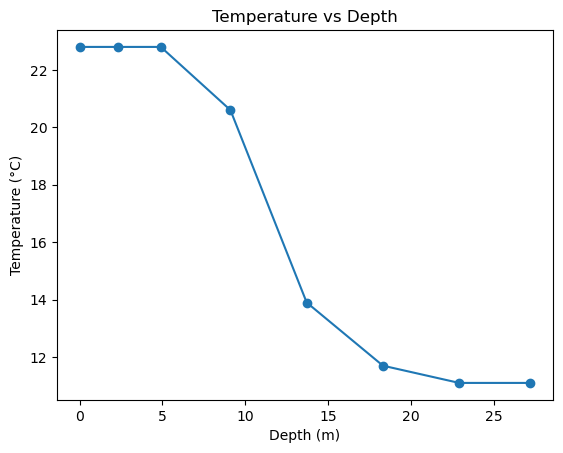

In [3]:
import matplotlib.pyplot as plt
plt.plot(z, T, 'o-')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Depth')
plt.show()

step    0: loss=107.0757, params=[16.93621059 11.5596998  12.35779287 -1.         -1.         -1.        ]
step 2000: loss=1.1173, params=[17.09995244  5.15006556 12.40543787 -0.99286395 -0.99059264 -0.98759705]
step 4000: loss=0.5050, params=[16.89453446  5.36014488 13.24617332 -0.83487289 -0.85587916 -0.86375418]
step 6000: loss=0.4837, params=[16.775       5.475      13.26995133 -0.82985409 -0.85366066 -0.86277328]
T(z) = 16.7750 + 5.4750 * tanh(-0.8299 (z - 13.27) + -0.8537 (z - 13.27)**2 + -0.8628 (z - 13.27)**3)


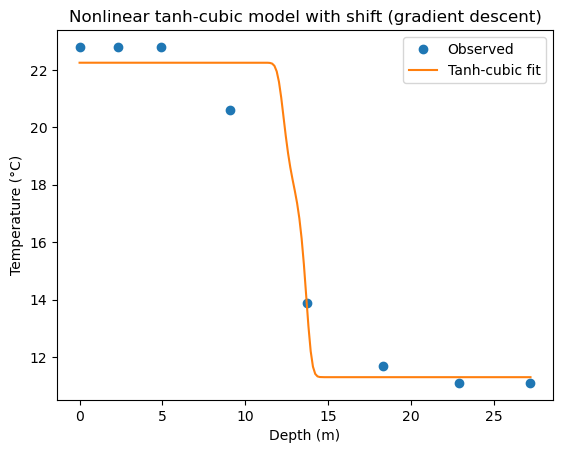

In [4]:
# Nonlinear cubic-like model using tanh envelope with a learnable depth shift.
# T(z) = d + a * tanh(b1*(z - z0) + b2*(z - z0)**2 + b3*(z - z0)**3)
def tanh_cubic_model(z, params):
    d, a, z0, b1, b2, b3 = params
    z_centered = z - z0
    poly = b1 * z_centered + b2 * z_centered**2 + b3 * z_centered**3
    return d + a * np.tanh(poly)

def loss_and_grad(params):
    d, a, z0, b1, b2, b3 = params
    z_centered = z - z0
    poly = b1 * z_centered + b2 * z_centered**2 + b3 * z_centered**3
    tanh_poly = np.tanh(poly)
    preds = d + a * tanh_poly
    err = preds - T
    loss = float(np.mean(err**2))

    sech2 = 1.0 - tanh_poly**2
    d_d = np.ones_like(z)
    d_a = tanh_poly
    d_z0 = a * sech2 * (-(b1 + 2 * b2 * z_centered + 3 * b3 * z_centered**2))
    d_b1 = a * sech2 * z_centered
    d_b2 = a * sech2 * z_centered**2
    d_b3 = a * sech2 * z_centered**3

    dL_dd = 2.0 * np.mean(err * d_d)
    dL_da = 2.0 * np.mean(err * d_a)
    dL_dz0 = 2.0 * np.mean(err * d_z0)
    dL_db1 = 2.0 * np.mean(err * d_b1)
    dL_db2 = 2.0 * np.mean(err * d_b2)
    dL_db3 = 2.0 * np.mean(err * d_b3)
    grad = np.array([dL_dd, dL_da, dL_dz0, dL_db1, dL_db2, dL_db3])
    return loss, grad

params = np.array([
    T.mean(),                # d: offset
    (T.max() - T.min()),     # a: amplitude
    z.mean(),                # z0: learnable shift to center depth
    -0.01,                    # b1
    0.02,                  # b2
    -0.00005,                 # b3
], dtype=float)
lr = 0.01
steps = 8000
for step in range(steps):
    loss, grad = loss_and_grad(params)
    params -= lr * grad
    params[3:] = np.clip(params[3:], -1.0, 1.0)  # keep polynomial weights stable
    if step % 2000 == 0:
        print(f"step {step:4d}: loss={loss:.4f}, params={params}")

d, a, z0, b1, b2, b3 = params
print(f"T(z) = {d:.4f} + {a:.4f} * tanh({b1:.4f} (z - {z0:.2f}) + {b2:.4f} (z - {z0:.2f})**2 + {b3:.4f} (z - {z0:.2f})**3)")

z_smooth = np.linspace(z.min(), z.max(), 200)
T_fit = tanh_cubic_model(z_smooth, params)
plt.figure()
plt.plot(z, T, 'o', label='Observed')
plt.plot(z_smooth, T_fit, '-', label='Tanh-cubic fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Nonlinear tanh-cubic model with shift (gradient descent)')
plt.legend()
plt.show()


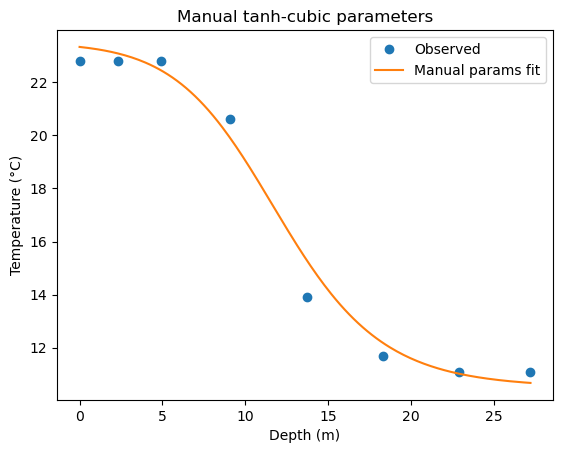

Manual parameters [d, a, b1, b2, b3]: [ 1.7e+01  6.5e+00  1.2e+01 -1.6e-01  1.5e-03 -2.0e-05]


In [5]:
# Manual parameter tweak for tanh-cubic model and plot
manual_params = np.array([
    17.0,    # d: baseline level
    6.5,     # a: amplitude (positive to give warm surface, cool deep)
    12.0,    # z0: center depth
    -0.16,   # b1
    0.0015,  # b2
    -2e-05,  # b3
], dtype=float)

z_plot = np.linspace(z.min(), z.max(), 200)
T_manual = tanh_cubic_model(z_plot, manual_params)

plt.figure()
plt.plot(z, T, 'o', label='Observed')
plt.plot(z_plot, T_manual, '-', label='Manual params fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Manual tanh-cubic parameters')
plt.legend()
plt.show()

print('Manual parameters [d, a, b1, b2, b3]:', manual_params)
